In [5]:
# file_folder_path = 'benchmarking/results/old_results/'
file_folder_path = ''

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
from typing import List, Dict, Optional, Tuple

def plot_model_comparison(
    csv_file: str,
    models: List[str],
    color_list: List[str] = ['#1f77b4', '#ff7f0e'],
    model_name_dict: Optional[Dict[str, List[str]]] = None,
    metric_name: str = 'Score',
    legend_name: str = 'Model Performance',
    title_name: str = 'Raw Model vs Baymin Model Comparison',
    plot_size: Tuple[int, int] = (12, 8),
    show_legend: bool = True,
    separate_bar_names: bool = True,
    show_grid: bool = False
):
    """
    Plot comparison between raw_model and baymin_model scores for specified models.
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing the data
    models : List[str]
        List of models to plot (e.g., ['gpt-oss:latest', 'qwen3:8b'])
    color_list : List[str]
        List of two colors for left and right bars (e.g., ['#1f77b4', '#ff7f0e'])
    model_name_dict : Dict[str, List[str]], optional
        Dictionary mapping model names to display names
        e.g., {'gpt-oss:latest': ['GPT-OSS', 'Baymin-GPT-OSS']}
    metric_name : str
        Name for the y-axis (default: 'Score')
    legend_name : str
        Name for the legend (default: 'Model Performance')
    title_name : str
        Title for the plot (default: 'Raw Model vs Baymin Model Comparison')
    plot_size : Tuple[int, int]
        Size of the plot (width, height) in inches (default: (12, 8))
    show_legend : bool
        Whether to show the legend (default: True)
    separate_bar_names : bool
        If True, shows separate names for each bar (e.g., "GPT-OSS" and "Baymin-GPT-OSS")
        If False, shows combined names (e.g., "GPT-OSS\nvs\nBaymin-GPT-OSS") (default: False)
    """
    
    # Read data from CSV using pandas for better column handling
    try:
        df = pd.read_csv(csv_file)
    except pd.errors.ParserError:
        # Fallback to csv reader if pandas fails due to parsing issues
        data = []
        with open(csv_file, 'r') as f:
            reader = csv.reader(f)
            header = next(reader)
            
            for row in reader:
                if len(row) >= 10:  # Ensure we have enough columns
                    model = row[6]  # model column
                    raw_score = float(row[8]) if row[8] else 0  # raw_model_score column
                    baymin_score = float(row[9]) if row[9] else 0  # baymin_score column
                    
                    if model in models:
                        data.append({
                            'model': model,
                            'raw_model_score': raw_score,
                            'baymin_score': baymin_score
                        })
        df = pd.DataFrame(data)
    
    # Filter data for specified models
    df_filtered = df[df['model'].isin(models)]
    
    if df_filtered.empty:
        print("No data found for the specified models.")
        return
    
    # Calculate average scores for each model
    model_stats = df_filtered.groupby('model').agg({
        'raw_model_score': 'mean',
        'baymin_score': 'mean'
    }).reset_index()
    
    # Set up the plot
    plt.figure(figsize=plot_size)
    
    # Set up bar positions
    x = np.arange(len(model_stats))
    width = 0.35
    
    # Create bars
    bars1 = plt.bar(x - width/2, model_stats['raw_model_score'], width, 
                    label='Raw Model', color=color_list[0], alpha=0.8)
    bars2 = plt.bar(x + width/2, model_stats['baymin_score'], width,
                    label='Baymin Model', color=color_list[1], alpha=0.8)
    
    ax = plt.gca()

    pos_raw = x - width/2
    pos_bay = x + width/2

    if model_name_dict:
        raw_labels   = [model_name_dict.get(m, [f"{m} (Raw)", f"{m} (Baymin)"])[0]
                        for m in model_stats['model']]
        baymin_labels = [model_name_dict.get(m, [f"{m} (Raw)", f"{m} (Baymin)"])[1]
                        for m in model_stats['model']]
    else:
        raw_labels   = [f"{m} (Raw)"   for m in model_stats['model']]
        baymin_labels = [f"{m} (Baymin)" for m in model_stats['model']]

    if separate_bar_names:
        # one label per bar (raw, baymin, raw, baymin, ...)
        tick_positions = np.concatenate([pos_raw, pos_bay])
        tick_labels    = raw_labels + baymin_labels
        ax.set_xticks(tick_positions, tick_labels)
    else:
        # one label per group (centered between the two bars)
        group_labels = [
            (f"{model_name_dict[m][0]}\nvs\n{model_name_dict[m][1]}")
            if model_name_dict and m in model_name_dict else m
            for m in model_stats['model']
        ]
        ax.set_xticks(x, group_labels)
    
    # Set labels and title
    plt.xlabel('Models', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.title(title_name, fontsize=14, fontweight='bold')
    
    # Show legend only if show_legend is True
    if show_legend:
        plt.legend(title=legend_name, fontsize=10)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Add grid for better readability
    grid_alpha = 0.3 if show_grid else 0
    plt.grid(show_grid, alpha=grid_alpha, axis='y')
    
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("=" * 50)
    for _, row in model_stats.iterrows():
        model = row['model']
        raw_avg = row['raw_model_score']
        baymin_avg = row['baymin_score']
        improvement = baymin_avg - raw_avg
        
        print(f"Model: {model}")
        print(f"  Raw Model Average: {raw_avg:.3f}")
        print(f"  Baymin Model Average: {baymin_avg:.3f}")
        print(f"  Improvement: {improvement:+.3f}")
        print(f"  Improvement %: {(improvement/raw_avg)*100:+.1f}%" if raw_avg > 0 else "  Improvement %: N/A")
        print("-" * 30)



/tmp/ipykernel_1597531/3180388591.py:149: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(show_grid, alpha=grid_alpha, axis='y')


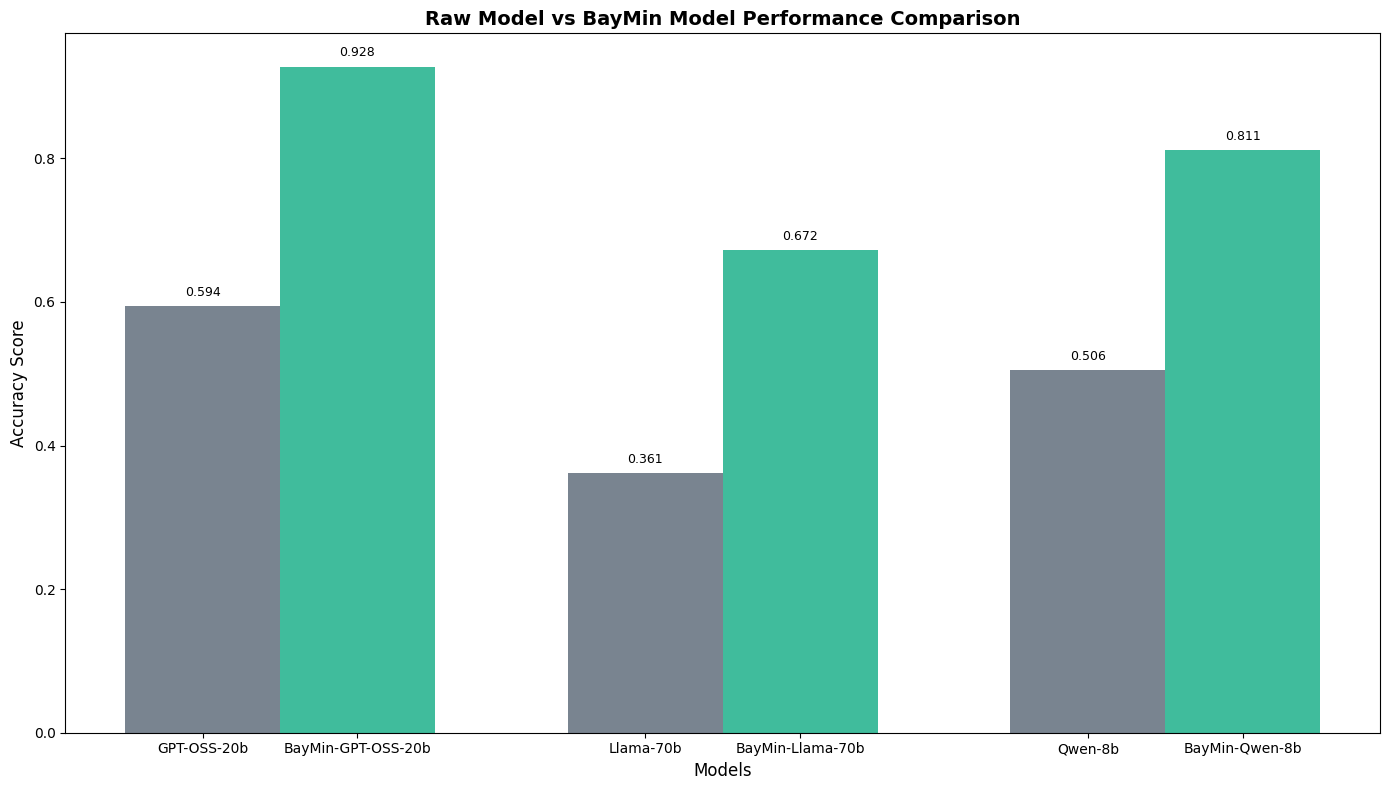


Summary Statistics:
Model: gpt-oss:latest
  Raw Model Average: 0.594
  Baymin Model Average: 0.928
  Improvement: +0.333
  Improvement %: +56.1%
------------------------------
Model: llama3.1:70b
  Raw Model Average: 0.361
  Baymin Model Average: 0.672
  Improvement: +0.311
  Improvement %: +86.2%
------------------------------
Model: qwen3:8b
  Raw Model Average: 0.506
  Baymin Model Average: 0.811
  Improvement: +0.306
  Improvement %: +60.4%
------------------------------


In [7]:
# Example usage of the plot_model_comparison function

# Test with all available models
plot_model_comparison(
    csv_file=file_folder_path + 'test_log.csv',
    models=['gpt-oss:latest', 'qwen3:8b', 'llama3.1:70b'],
    color_list=['#576574', '#10ac84'],  
    model_name_dict={
        'gpt-oss:latest': ['GPT-OSS-20b', 'BayMin-GPT-OSS-20b'],
        'qwen3:8b': ['Qwen-8b', 'BayMin-Qwen-8b'],
        'llama3.1:70b': ['Llama-70b', 'BayMin-Llama-70b']
    },
    metric_name='Accuracy Score',
    show_legend=False,
    title_name='Raw Model vs BayMin Model Performance Comparison',
    plot_size=(14, 8)
)


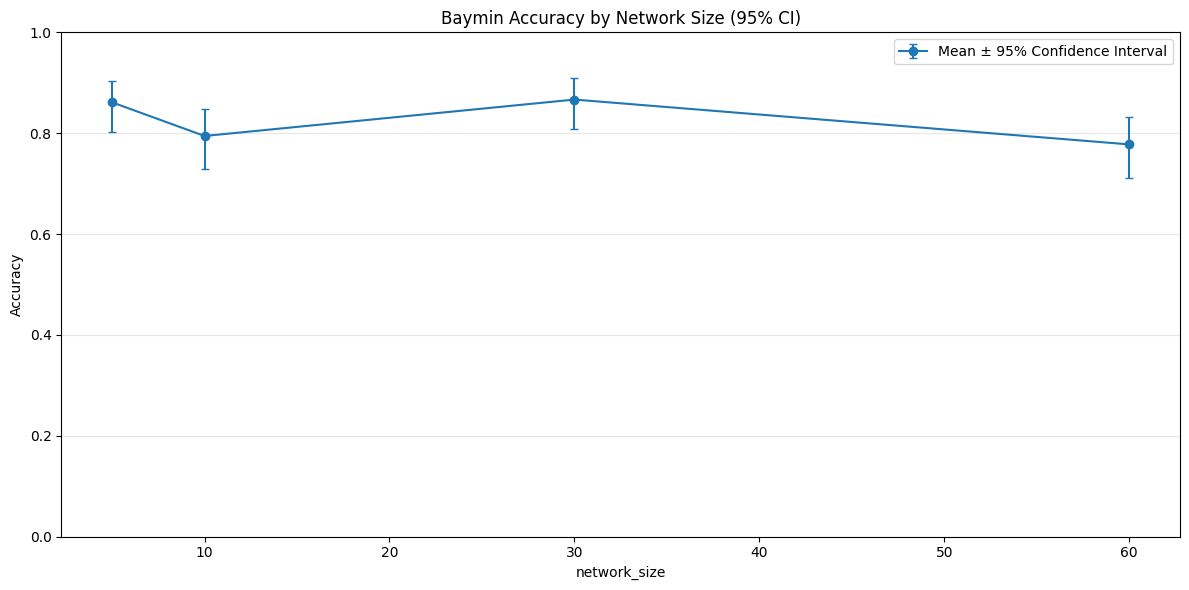

In [9]:
file_folder_path = 'benchmarking/results/old_results/'
# file_folder_path = ''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple
from scipy.stats import beta

# Wilson score interval for binomial proportion
def _wilson_ci(num_success: np.ndarray, n: np.ndarray, z: float = 1.96) -> Tuple[np.ndarray, np.ndarray]:
    p_hat = np.divide(num_success, n, out=np.zeros_like(num_success, dtype=float), where=n>0)
    denom = 1.0 + (z**2)/n
    center = (p_hat + (z**2)/(2*n)) / denom
    half_width = (z * np.sqrt((p_hat*(1 - p_hat))/n + (z**2)/(4*(n**2)))) / denom
    lower = np.clip(center - half_width, 0.0, 1.0)
    upper = np.clip(center + half_width, 0.0, 1.0)
    return lower, upper


def _clopper_pearson_ci(num_success: np.ndarray, n: np.ndarray, alpha: float = 0.05) -> Tuple[np.ndarray, np.ndarray]:
    k = np.asarray(num_success, dtype=float)
    n = np.asarray(n, dtype=float)
    lower = beta.ppf(alpha/2, k, n - k + 1)
    upper = beta.ppf(1 - alpha/2, k + 1, n - k)
    lower = np.where(k == 0, 0.0, lower)
    upper = np.where(k == n, 1.0, upper)
    return lower, upper


def plot_baymin_accuracy_with_ci(
    csv_file: str,
    x_axis: str = "network_size",
    title: str = "Baymin Accuracy with 95% CI",
    figsize: Tuple[int, int] = (12, 6),
    sort_by_time: bool = True,
    rolling_window: Optional[int] = None,
    grid: bool = True,
    aggregate_by_x: Optional[bool] = None,
    ci_method: str = "clopper",  # "clopper" (exact) or "wilson"
    mean_line_color: str = "#1f77b4",
    ci_line_color: str = "#1f77b4",
    rolling_mean_line_color: str = "#ff7f0e",
    error_bar_color: str = "#1f77b4",
):
    """
    Plot Baymin accuracy as a line chart with a 95% confidence interval.
    - Reads 'baymin_score' (0/1) from the CSV.
    - Sorts rows (by timestamp if available) to create a stable sequence.
    - Computes cumulative accuracy and Wilson 95% CI at each step.
    - Optionally overlays a rolling-mean accuracy curve.

    Parameters:
    - csv_file: path to baymin_test_log.csv
    - x_axis: which column to use for X labels (default 'question_index')
    - title: plot title
    - figsize: figure size
    - sort_by_time: if True and 'timestamp' exists, sort by timestamp; else by x_axis
    - rolling_window: optional window size for a rolling mean overlay (e.g., 20)
    - grid: show grid lines
    """
    df = pd.read_csv(csv_file)

    if 'baymin_score' not in df.columns:
        raise ValueError("CSV must contain 'baymin_score' column (0/1).")

    # If aggregating by x (e.g., network_size), compute mean accuracy and CI per group
    if aggregate_by_x is None:
        aggregate_by_x = x_axis in df.columns and x_axis != 'timestamp'

    if aggregate_by_x and (x_axis in df.columns):
        # Clean x values (e.g., network_size may be numeric in string form)
        x_series = pd.to_numeric(df[x_axis], errors='coerce') if df[x_axis].dtype == object else df[x_axis]
        g = df.assign(_x=x_series).dropna(subset=['_x'])
        g['_y'] = g['baymin_score'].fillna(0).astype(float)
        grouped = g.groupby('_x').agg(num_success=('_y', 'sum'), n=('_y', 'size')).reset_index()
        grouped = grouped.sort_values('_x')
        acc = grouped['num_success'] / grouped['n']
        if ci_method == "clopper":
            lo, up = _clopper_pearson_ci(grouped['num_success'].to_numpy(), grouped['n'].to_numpy())
            ci_label = "95% Confidence Interval"
        else:
            lo, up = _wilson_ci(grouped['num_success'].to_numpy(), grouped['n'].to_numpy())
            ci_label = "95% Confidence Interval"
        x_vals = grouped['_x'].to_numpy()

        plt.figure(figsize=figsize)
        yerr = np.vstack([acc - lo, up - acc])
        plt.errorbar(x_vals, acc, yerr=yerr, fmt='o-', color=error_bar_color, capsize=3, label=f"Mean ± {ci_label}")

        plt.ylim(0, 1)
        plt.xlabel(x_axis)
        plt.ylabel('Accuracy')
        plt.title(title)
        if grid:
            plt.grid(True, axis='y', alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        return

    # Otherwise: sequential cumulative plot (time-ordered)
    # Determine sequence order
    if sort_by_time and 'timestamp' in df.columns:
        try:
            df['_ts'] = pd.to_datetime(df['timestamp'])
            df = df.sort_values('_ts').reset_index(drop=True)
        except Exception:
            df = df.sort_values(x_axis if x_axis in df.columns else 'index').reset_index(drop=True)
    else:
        df = df.sort_values(x_axis if x_axis in df.columns else 'index').reset_index(drop=True)

    # Build x values (fallback to sequential index if duplicates/non-monotonic)
    x_seq = np.arange(1, len(df)+1)
    if x_axis in df.columns:
        x_candidate = df[x_axis].to_numpy()
        has_dup = pd.Series(x_candidate).duplicated().any()
        is_mono = pd.Series(x_candidate).is_monotonic_increasing
        x_vals = x_seq if (has_dup or not is_mono) else x_candidate
    else:
        x_vals = x_seq

    # Cumulative accuracy and Wilson CI
    y = df['baymin_score'].fillna(0).astype(float).to_numpy()
    cum_success = np.cumsum(y)
    n = np.arange(1, len(y)+1)
    cum_acc = cum_success / n
    lower, upper = _wilson_ci(cum_success, n)

    plt.figure(figsize=figsize)
    plt.plot(x_vals, cum_acc, color=mean_line_color, label="Cumulative Accuracy", linewidth=2)
    plt.fill_between(x_vals, lower, upper, color=ci_line_color, alpha=0.15, label="95% CI (Wilson)")

    # Optional rolling mean overlay
    if rolling_window and rolling_window > 1:
        roll = pd.Series(y).rolling(rolling_window, min_periods=max(1, rolling_window//2)).mean().to_numpy()
        plt.plot(x_vals, roll, color=rolling_mean_line_color, label=f"Rolling mean ({rolling_window})", linewidth=1.5, alpha=0.9)

    plt.ylim(0, 1)
    plt.xlabel(x_axis if x_axis in df.columns else 'index')
    plt.ylabel('Accuracy')
    plt.title(title)
    if grid:
        plt.grid(True, axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_baymin_accuracy_with_ci(
    csv_file=file_folder_path + 'baymin_test_log.csv',
    x_axis='network_size',
    title='Baymin Accuracy by Network Size (95% CI)',
    figsize=(12, 6),
    sort_by_time=True,
    rolling_window=None,
    grid=True,
    aggregate_by_x=True,
    ci_method='wilson',
)
